**Module 9 Week 5 Assignment**

**Introduction**


The problem I am choosing to discuss would be where best to open a restaurant in the city of Paris.
As we all know, the city is well known for food. There are many restaurants and competition for customers is very high.

If the restaurant is opened at a location that is not ideal, it can severely impact the number of customers and revenue.
Hence it is important to decide where best to set up your restaurant.
In this assignment, I am going to use data to determine and recommend several ideal locations.

Target audience: People intending to open restaurant in Paris area.

**Data**

The data required for this project will be the following:
1) Coordinates of nearby restaurants in Paris
2) Latitude and Longitude value of Paris center

A cluster of restaurants in Paris within 5KM radius of the city center will be generated using four square API.
Our aim is to find out which parts within the 5KM radius boundary is least populated by restaurants and hence will be more ideal for setting up a new restaurant due to decreased competition.
The four square API developer account I am using would be a free one and hence would only return 50 results per call..
For this reason, I have decided to restrict the four square API call's radius parameter to 5KM so that we can draw meaningful result.

The latitude and longitude values of Paris will scraped from the website:
https://www.latlong.net/place/paris-france-1666.html


**Methodology**

**We first import all the necessary libraries and download the necessary packages needed for this project**

In [99]:
#Import necessary libraries
import pandas as pd
from pandas.io.json import json_normalize # for json_normalize function
import requests
import folium #for visualising the data

#Download necessary packages
!pip install BeautifulSoup4
!pip install requests

We start by scraping the Longitude and Latitude values of Paris city center from the website using Beautiful Soup

In [100]:
URL = 'https://www.latlong.net/place/paris-france-1666.html'
r = requests.get(URL) 
from bs4 import BeautifulSoup  
soup = BeautifulSoup(r.content, 'html5lib') 
#print(soup.prettify())


**By selecting inspect element on the browser, we notice that the coordinates of Paris can be found embedded in the strong tags. Hence we search the strong tag to obtain the values.**

In [101]:
#Getting Longitude and Latitude values from <strong> tag from the website
paris_coor = soup.find("strong").text
print(paris_coor)
pc = paris_coor.split(",")
lat = float(pc[0])
long =float(pc[1])
print(lat)
print(long)

48.864716, 2.349014
48.864716
2.349014


**We then input Client_ID, Client_Secret and VERSION of foursquare**

In [102]:
CLIENT_ID ='QE4UE15YSNENOVJDQW4CH1SKPZCEDBD1N1NF4HZZ24HDHXTL'
CLIENT_SECRET ='KFJWOQXKISDU1HYFBFWSHXLFJRLQOSEZHWAY5QZBGHEXA1BU'
VERSION ='20180605'

**We then get a list of nearby restaurants to Paris center from foursquare using requests.get**

In [103]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, 'restaurant', 5000, 1000)
get_restaurants = requests.get(url).json()
#get_restaurants

**Data cleaning below:**

In [104]:
# assign relevant part of JSON to venues
venues = get_restaurants['response']['venues']
print(len(venues)) #checking how many venues got imported

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

50


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood,venuePage.id
0,59ab059c86bc49021b313ca9,Restaurant Le Mona Lisa,"[{'id': '4bf58dd8d48988d10c941735', 'name': 'F...",v-1580969915,False,47 rue Berger,48.862198,2.342542,"[{'label': 'display', 'lat': 48.86219809159731...",550,75001,FR,Paris,Île-de-France,France,"[47 rue Berger, 75001 Paris, France]",NaN,NaN,NaN
1,4e2b2d0ad22d3f83c88c7029,Le Restaurant des Poètes,"[{'id': '4bf58dd8d48988d10c941735', 'name': 'F...",v-1580969915,False,12 passage Molière,48.862321,2.351590,"[{'label': 'display', 'lat': 48.86232131013030...",326,75003,FR,Paris,Île-de-France,France,"[12 passage Molière, 75003 Paris, France]",NaN,NaN,NaN
2,4f8e6f92e4b0cb228782dc5f,Restaurant Hotel Little Palace,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1580969915,False,Hotel Little Palace,48.867386,2.353741,"[{'label': 'display', 'lat': 48.867386, 'lng':...",456,75003,FR,Paris,Île-de-France,France,"[Hotel Little Palace (4 rue Salomon de Caus), ...",4 rue Salomon de Caus,NaN,NaN
3,52cf091111d2d9bb920d6122,Restaurant Costes Saint-Honoré,"[{'id': '4bf58dd8d48988d10c941735', 'name': 'F...",v-1580969915,False,Hôtel Costes,48.866698,2.327894,"[{'label': 'display', 'lat': 48.86669789450374...",1562,NaN,FR,Paris,Île-de-France,France,"[Hôtel Costes (239 rue Saint-Honoré), Paris, F...",239 rue Saint-Honoré,NaN,NaN
4,4cbb05054352a1cd0d4396f5,Le Restaurant du Musée d'Orsay,"[{'id': '4bf58dd8d48988d10c941735', 'name': 'F...",v-1580969915,False,1 rue de la Légion d'Honneur,48.860300,2.325392,"[{'label': 'display', 'lat': 48.86029986248957...",1798,75007,FR,Paris,Île-de-France,France,"[1 rue de la Légion d'Honneur, 75007 Paris, Fr...",NaN,NaN,NaN


In [105]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Restaurant Le Mona Lisa,French Restaurant,47 rue Berger,48.862198,2.342542,"[{'label': 'display', 'lat': 48.86219809159731...",550,75001,FR,Paris,Île-de-France,France,"[47 rue Berger, 75001 Paris, France]",NaN,NaN,59ab059c86bc49021b313ca9
1,Le Restaurant des Poètes,French Restaurant,12 passage Molière,48.862321,2.351590,"[{'label': 'display', 'lat': 48.86232131013030...",326,75003,FR,Paris,Île-de-France,France,"[12 passage Molière, 75003 Paris, France]",NaN,NaN,4e2b2d0ad22d3f83c88c7029
2,Restaurant Hotel Little Palace,Restaurant,Hotel Little Palace,48.867386,2.353741,"[{'label': 'display', 'lat': 48.867386, 'lng':...",456,75003,FR,Paris,Île-de-France,France,"[Hotel Little Palace (4 rue Salomon de Caus), ...",4 rue Salomon de Caus,NaN,4f8e6f92e4b0cb228782dc5f
3,Restaurant Costes Saint-Honoré,French Restaurant,Hôtel Costes,48.866698,2.327894,"[{'label': 'display', 'lat': 48.86669789450374...",1562,NaN,FR,Paris,Île-de-France,France,"[Hôtel Costes (239 rue Saint-Honoré), Paris, F...",239 rue Saint-Honoré,NaN,52cf091111d2d9bb920d6122
4,Le Restaurant du Musée d'Orsay,French Restaurant,1 rue de la Légion d'Honneur,48.860300,2.325392,"[{'label': 'display', 'lat': 48.86029986248957...",1798,75007,FR,Paris,Île-de-France,France,"[1 rue de la Légion d'Honneur, 75007 Paris, Fr...",NaN,NaN,4cbb05054352a1cd0d4396f5


In [106]:
dataframe_filtered.name

0                       Restaurant Le Mona Lisa
1                      Le Restaurant des Poètes
2                Restaurant Hotel Little Palace
3                Restaurant Costes Saint-Honoré
4                Le Restaurant du Musée d'Orsay
5            Restaurant Aux Tours de Notre-Dame
6                                Restaurant Erh
7                     Le Grand Amour Restaurant
8                             Restaurant Deluxe
9                            Restaurant Sichuan
10                             Restaurant Au 35
11                         Restaurant Ayào.阿耀面点
12                           Jet Set Restaurant
13          Restaurant Le Meurice Alain Ducasse
14                       Restaurant Mon Paris !
15                      Restaurant d'Entreprise
16                            Restaurant Coréen
17                             Elise Restaurant
18                    Restaurant 58 Tour Eiffel
19                      A Hot Pot Restaurant 一家
20         Restaurant de Bourgogne Chez 

**Next, we plot the center of Paris (Red marker) followed by the nearby restaurants (Blue marker) on folium.**
**We also add a blue radius of 5KM radius to demarcate the boundaries we are working with in this project**

In [107]:
# Adding spots on the Paris Map
venues_map = folium.Map(location=[lat, long], zoom_start=12) # generate map centred around the center of Paris

# add a red circle marker to represent the center of Paris
folium.features.CircleMarker(
    [lat, long],
    radius=10,
    color='red',
    popup='Center of Paris',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

#add a green circle to demarcate the border of the area we are looking at for this project (5KM radius)

folium.Circle([48.864716, 2.349014],
                    radius=5000
                   ).add_to(venues_map)

# add the restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup= 'restaurant',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

**We then import KMeans from sklearn.cluster to analyze the nearby restaurants.**

In [108]:
from sklearn.cluster import KMeans
import numpy as np # library for vectorized computation

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
 
print('Libraries imported.')

Libraries imported.


**We use K means clustering to find out the centroids (in this case I choose 2 centroids, n_clusters=2) of the 50 nearby restaurants.
We are then going compare the distances from various parts of Paris city to the 2 centroids (of the nearby restaurants) to find out which part of the city is less populated with restaurants.**

Reason for using kmeans clustering to find the 2 centroids is to reduce the computation required as compared to if we find the distances from all the 180 points to all the individual 50 restaurants instead. If we use kmeans clustering, we only needed to find the distances from all 180 points to the 2 centroids, freeing much space and capacity required.

In [109]:
# Start doing kmeans
k_means = KMeans(init="k-means++", n_clusters=2, n_init=12)
coordinates = dataframe_filtered[['lat','lng']]
print(type(coordinates))
coordinates = np.array(coordinates)
print(type(coordinates))


k_means.fit(coordinates)
k_means_labels = k_means.labels_
k_means_labels
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers 

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


array([[48.86784983,  2.32599395],
       [48.86228552,  2.35384696]])

**We then plot the Kmeans graph**

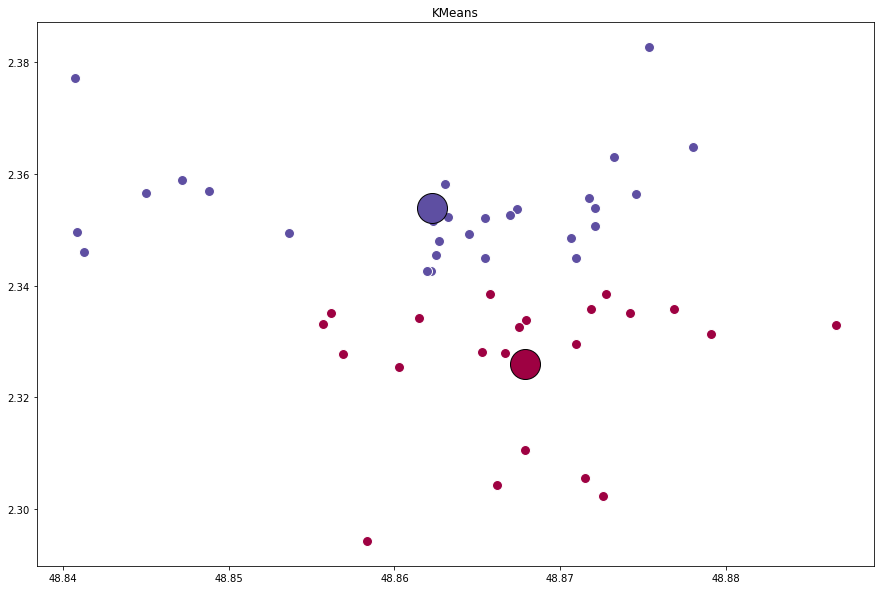

In [110]:
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15, 10))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(-10000, 10000, len(set(k_means_labels))))

# create a plot
ax = fig.add_subplot(1, 1, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(len([[48.81911352606138,  2.2493037148296553], [48.888035 , 2.353741]])), colors):

    # create a list of all datapoints, where the datapoitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # plot the datapoints with color col.
    ax.plot(coordinates[my_members, 0], coordinates[my_members, 1], 'w', markerfacecolor=col, marker='.',markersize = 20)
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=30)

# title of the plot
ax.set_title('KMeans')

# remove x-axis ticks
#ax.set_xticks(())

# remove y-axis ticks
#ax.set_yticks(())

# show the plot
plt.show()

In [111]:
print(k_means_cluster_centers)
def Extract(lst): 
    return [item[0] for item in lst]
def Extract2(lst): 
    return [item[1] for item in lst]
Extract2(k_means_cluster_centers)

[[48.86784983  2.32599395]
 [48.86228552  2.35384696]]


[2.3259939530120426, 2.353846962733849]

**We then plot the 2 centroids (pink markers) on folium**

In [112]:
#center of the centroids
#[[48.85836741  2.29564351]
# [48.86223987  2.33143606]]

# add the 2 centoids of the clusters of italian restaurants as pink circle markers
for lat, l in zip(Extract(k_means_cluster_centers), Extract2(k_means_cluster_centers)):
    folium.features.CircleMarker(
        [lat, long],
        radius=10,
        color='pink',
        popup='centroid of restaurants',
        fill = True,
        fill_color='pink',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map


**We define the get_lag_lg function that will generate a set of 180 points within Paris.**

In [113]:
import math

#Define function that plots various points on the map. We use this function to generate numerous points so we can compare distances to the 2 centroids.
def get_lat_lg(bearing, lat1, lon1, d):# bearing in degrees, D in KM, lat1 and lon1 in degrees.
    """
    The function basically gives you the latitude and longitude value a point that is "d" meters away from Paris Center.     
    """
    R = 6378.1
    brng = bearing*np.pi/180 #convert bearing from degrees to radians
    
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return(lat2,lon2)


**We generate a dataframe of 180 points within Paris using get_lat_lg and plot them (light purple markers) on folium to double confirm**

In [114]:
#Using the get_lat_lg function above, we loop it through a loop to generate a series of candidate points that is also within the 5KM radius of Paris Center
points = pd.DataFrame(columns = ['Latitude','Longitude'])
print(points)
for d in range(0, 6, 1):
    for bearing in range(0,360,12):
        lat2, lon2 = get_lat_lg(bearing, 48.864716, 2.349014, d)
        points = points.append({'Latitude': lat2, 'Longitude': lon2}, ignore_index=True) #adding all the points to a dataframe for use later
        folium.features.CircleMarker(
        [lat2, lon2],
        radius=10,
        color='none',
        popup='Center of Paris',
        fill = True,
        fill_color = 'purple',
        fill_opacity = 0.2
    ).add_to(venues_map)

print(points)

Empty DataFrame
Columns: [Latitude, Longitude]
Index: []
      Latitude  Longitude
0    48.864716   2.349014
1    48.864716   2.349014
2    48.864716   2.349014
3    48.864716   2.349014
4    48.864716   2.349014
..         ...        ...
175  48.887159   2.289857
176  48.894760   2.298243
177  48.901047   2.308852
178  48.905745   2.321220
179  48.908650   2.334806

[180 rows x 2 columns]


In [115]:
#We generate the folium map to see all the candidate points (light purple)
venues_map

**We define the haversine function to measure distance from the 180 points to the 2 centroids so that we know which of the 180 points are the furthest away from the cluster of restaurants.**

In [116]:
#haversine(lon1, lat1, lon2, lat2)# compare dist vs first centroid 48.86743241  2.32462143
#haversine(lon1, lat1, lon2, lat2)# compare dist vs second centroid 48.86229665  2.35426281


def haversine(lat1, lon1, lat2, lon2): 
      
    # distance between latitudes 
    # and longitudes 
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
  
    # convert to radians 
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
  
    # apply formulae 
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2)); 
    rad = 6371
    c = 2 * math.asin(math.sqrt(a)) 
    return rad * c 


**We create a dataframe Compare_Dist to contain all the distance values from the 180 points to the centroids**

In [117]:

Compare_Dist = pd.DataFrame(columns = ["Distance to Cent 1","Distance to Cent 2", "Avg Dist", "Lat of point", "Long of point"])


print(Compare_Dist)



for index, row in points.iterrows():
    Dist1 = haversine( 48.86743241, 2.32462143, row['Latitude'], row['Longitude'])
    Dist2 = haversine( 48.86229665, 2.35426281, row['Latitude'], row['Longitude'])
    Avg_Dist = (Dist1 + Dist2)/2
    Compare_Dist = Compare_Dist.append({"Distance to Cent 1": Dist1, "Distance to Cent 2": Dist2, "Avg Dist": Avg_Dist, "Lat of point": row['Latitude'],"Long of point": row['Longitude']},ignore_index=True)  
print(Compare_Dist)   



Empty DataFrame
Columns: [Distance to Cent 1, Distance to Cent 2, Avg Dist, Lat of point, Long of point]
Index: []
     Distance to Cent 1  Distance to Cent 2  Avg Dist  Lat of point  \
0              1.809615            0.468818  1.139216     48.864716   
1              1.809615            0.468818  1.139216     48.864716   
2              1.809615            0.468818  1.139216     48.864716   
3              1.809615            0.468818  1.139216     48.864716   
4              1.809615            0.468818  1.139216     48.864716   
..                  ...                 ...       ...           ...   
175            3.357800            5.461611  4.409705     48.887159   
176            3.599169            5.460070  4.529620     48.894760   
177            3.911569            5.439889  4.675729     48.901047   
178            4.267473            5.401749  4.834611     48.905745   
179            4.643240            5.346954  4.995097     48.908650   

     Long of point  
0         2

**We then filter out the top 3 values based on average distance column**

In [118]:
print(Compare_Dist.nlargest(3, 'Avg Dist'))
print("The top 3 ideal points are:")
print("1)[48.869391,2.416924]")
print("2)[48.860001,2.416912]")
print("3)[48.878578,2.413968]")

     Distance to Cent 1  Distance to Cent 2  Avg Dist  Lat of point  \
157            6.754829            4.650883  5.702856     48.869391   
158            6.801402            4.590094  5.695748     48.860001   
156            6.650979            4.727250  5.689114     48.878578   

     Long of point  
157       2.416924  
158       2.416912  
156       2.413968  
The top 3 ideal points are:
1)[48.869391,2.416924]
2)[48.860001,2.416912]
3)[48.878578,2.413968]


**We plot the 3 furthest points on folium. They are the 3 red markers.**

In [119]:
#Plotting the furthest 3 points to the 2 centroids on the map to do a sanity check
folium.features.CircleMarker(
    [48.869391, 2.416924],
    radius=10,
    color='red',
    popup='Furthest point',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

folium.features.CircleMarker(
    [48.860001, 2.416912],
    radius=10,
    color='red',
    popup='Furthest point',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

folium.features.CircleMarker(
    [48.878578, 2.413968],
    radius=10,
    color='red',
    popup='Furthest point',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

venues_map

**Results**

As the restaurants (blue points) area all clustered around Paris center, we expect the results to all be at the perimeter of the 5KM radius, which turned out to be the case. 
For this project, the 3 ideal points (red points) all lie on the perimeter of the 5km radius circle.

**Discussion**

In this project, we compare the distance from all points to the 2 centroids of the cluster of restaurants.

There is also an alternative method to do this.
One could consider checking if there are any restaurants near the vicinity of each candidate point. E.g Whether there are any restaurants in the nearby 1km of each point. In my opinion, this method is more complicated and hence might require more computation power.

The scope of this project could be further expanded as well to filter foursquare based on "Food" keyword or "Cafe" keyword asa well depending the kind of food place that the future owner is thinking of opening.

**Conclusion**

In this report, we generated cluster of restaurants near Paris from foursquare.
Subsequently we used K means clustering to find the 2 centroids of the cluster and then used haversine formula to calculate the distance.
As per results, it coincides with logical thinking that the points all lie at the perimeter since the 2 centroids are relatively central.

This concludes my capstone project.
Thank you for reading!
